<div>
    <table>
        <tr>
            <td>
                <center>
                    <h1>Wurst Introduction</h1>
                     <a href="https://www.psi.ch/en/ta/people/romain-sacchi">Karin Treyer</a> (PSI)
                    <br><br>
                    Duration: 1 hour 30 minutes.
                </center>
            </td>
        </tr>
    </div>

Github repository: [https://github.com/polca/wurst](https://github.com/polca/wurst)

Documentation: [https://wurst.readthedocs.io/](https://wurst.readthedocs.io/)

Wurst authors: Chris Mutel, Brian Cox

<div class="alert alert-info">
Note: we will be using <a href="https://docs.brightway.dev/en/latest/content/installation/index.html">Brightway 2.5</a>, not <a href="https://docs.brightway.dev/en/legacy/">Brightway 2</a>. From the user end side, very little differ between the two. The code executed throughout this notebook works with both versions... probably.
</div>


### Scenario: A world without fossil fuels

#### Background:
By 2050, fossil fuels in power generation are phased out due to stringent climate policies and technological advancements in renewables.


#### Objective:

1. Replace the contribution of fossil-based technologies in electricity markets with non-hydro renewables throughout the database.
The former share of fossil-based electricity should be redistributed evenly across already supplying renewables.

2. Compare the electricity markets, at low-voltage level with respect to Climate Change, Fine Particle emissions and Abiotic Resource Depletion. Can you identify some trade-offs?

### 1. Import:

Load the necessary libraries (`wurst`, `bw2data`, and maybe a plotting library like `matplotlib`).

In [1]:
import wurst
import wurst.searching as ws
import bw2io, bw2data
import matplotlib.pyplot as plt
from prettytable import PrettyTable

ModuleNotFoundError: No module named 'wurst'

Select/activate a `bw2data` project where you have an ecoinvent database.

In [2]:
list(bw2data.projects)

[Project: ei39,
 Project: simapro,
 Project: bw25,
 Project: bw25_intro,
 Project: carbon fiber 2,
 Project: wurst,
 Project: ecoinvent-3.10-consequential,
 Project: ecoinvent-3.10-EN15804,
 Project: ecoinvent-3.10-cutoff,
 Project: ecoinvent-3.8-cutoff,
 Project: ecoinvent-3.9.1-cutoff,
 Project: default,
 Project: ei310,
 Project: ecoinvent-3.9.1-consequential,
 Project: ecoinvent-3.8-consequential,
 Project: carbon fiber 3,
 Project: premise,
 Project: ,
 Project: ecoinvent-3.7.1-cutoff]

In [5]:
bw2data.projects.set_current("bw25")

In [6]:
bw2data.databases

Databases dictionary with 14 object(s):
	PV + storage
	PV 2035
	PV 2050
	PV 2050 - eff
	PV 2050 - eff - lifetime
	carbon fiber
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	test_bw25
	test_bw25 2
	test_bw25 3
	test_bw25 4
	test_bw25 5
	wafer

Using `wurst`, extract the ecoinvent database to turn it into a list of dictionaries.

In [7]:
db = wurst.extract_brightway2_databases("ecoinvent-3.10-cutoff")

Getting activity data


100%|█████████████████████████████████| 23523/23523 [00:00<00:00, 420325.62it/s]


Adding exchange data to activities


100%|████████████████████████████████| 743409/743409 [00:20<00:00, 36256.86it/s]


Filling out exchange data


100%|██████████████████████████████████| 23523/23523 [00:01<00:00, 17768.38it/s]


Build `wurst` filters to select only markets for electricity (high, medium, and low voltage). Filter out datasets specific to industries (coal, aluminium, railways, etc.) or for certified renewable electricity.

In [8]:
market_filters = [
    ws.contains("name", "market for electricity"),
    ws.equals("unit", "kilowatt hour"),
    ws.exclude(ws.either(
        *[
            ws.contains("name", name) for name in [
                "product",
                "generic",
                "aluminium",
                "reuse",
                "industry",
                "Railways",
                "mining"
            ]
        ]
    )),
]

In [ ]:
#check if the filters are working

print(ds.name) #getting only the names

In [ ]:


for ds in ws.get_many(
    db,
    *market_filters
):

Iterate through the database using the filters you built above. Inside each dataset, iterate over the technosphere exchanges. You may need to ignore exchanges that represent market losses, for example. Try to distinguish suppliers of fossil-based electricity from renewable ones.

In [9]:
technosphere_filters = [
    ws.equals("unit", "kilowatt hour"),
    ws.exclude(ws.contains("name", "market for")),
    ws.exclude(ws.contains("name", "voltage")),
]

In [10]:
fossil_suppliers = [
    "coal", "gas", "lignite", "oil", "peat"
]
renewable_suppliers = [
    "photovoltaic", "wind"
]

In [11]:
modifications = []
countries_wo_renew = []

for ds in ws.get_many(
    db,
    *market_filters
):
    # first, we check if there are renewable electricity suppliers
    number_renewables = len([x for x in ws.technosphere(ds, *technosphere_filters) if any(y in x["name"] for y in renewable_suppliers)])
    # we also need to check if there are fossil electricity suppliers
    number_fossil = len([x for x in ws.technosphere(ds, *technosphere_filters) if any(y in x["name"] for y in fossil_suppliers)])

    
    if number_fossil > 0 and number_renewables > 0:
        shares = {}
        # we iterate a first time to collect current shares
        for techno in ws.technosphere(
            ds,
            *technosphere_filters
            ):
            shares[(techno["name"], techno["location"])] = {"old": techno["amount"]}
    
        # we iterate a second time to zero-out fossil-based electricity
        surplus = 0
        for techno in ws.technosphere(
            ds,
            *technosphere_filters
            ):
            
            if any(x in techno["name"] for x in fossil_suppliers):
                modifications.append(
                    [ds["name"].split(", ")[-1], ds["location"], techno["name"][:30], "{:.2f}".format(techno["amount"]), 0]
                )
                surplus += techno["amount"]
                techno["amount"] = 0
    
        # we iterate a third time to distribute the surplus
        
        for techno in ws.technosphere(
            ds,
            *technosphere_filters
            ):
            if any(x in techno["name"] for x in renewable_suppliers):
                new_share = shares[(techno["name"], techno["location"])]["old"] + (surplus / number_renewables)
                modifications.append(
                    [ds["name"].split(", ")[-1], ds["location"], techno["name"][:30], "{:.2f}".format(techno["amount"]), "{:.2f}".format(new_share)]
                )
                techno["amount"] = new_share

table = PrettyTable(["Name", "Loc", "Tech", "Old share", "New share",])
table.add_rows(modifications)
print(table)

+--------------+-----------------------+--------------------------------+-----------------------+-----------------------+
|     Name     |          Loc          |              Tech              |       Old share       |       New share       |
+--------------+-----------------------+--------------------------------+-----------------------+-----------------------+
| high voltage |           PT          | heat and power co-generation,  |   0.0036260679984655  |           0           |
| high voltage |           PT          |  electricity production, oil   |   0.0142027727897208  |           0           |
| high voltage |           PT          | electricity production, hard c |   0.0443906388980669  |           0           |
| high voltage |           PT          | electricity production, natura |    0.23758306351299   |           0           |
| high voltage |           PT          | electricity production, wind,  |  0.00891925924521949  |  0.10885344031163388  |
| high voltage |        

In [35]:
unique_countries = list(set([m[1] for m in modifications]))

Export the database back to the `brightway` project.

In [12]:
wurst.write_brightway2_database(db, "no more fossil fuels")

23523 datasets
	743409 exchanges
	Links to the following databases:
		ecoinvent-3.10-biosphere (449622 exchanges)
		no more fossil fuels (293787 exchanges)
	0 unlinked exchanges (0 types)
		
09:47:02 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|████████████████████████████████████| 23523/23523 [00:49<00:00, 470.87it/s]

09:48:00 [info     ] Vacuuming database            


Created database: no more fossil fuels


Build a list of functional units to compare the new electricity markets with the original ones.

In [36]:
FU = [
    act for db in [
        "ecoinvent-3.10-cutoff", "no more fossil fuels"
    ] for act in bw2data.Database(db) if act["name"] == "market for electricity, low voltage"
    and act["unit"] == "kilowatt hour" and act["location"] in unique_countries
]

In [37]:
len(FU)

246

In [58]:
methods = [
    ('IPCC 2021', 'climate change: fossil', 'global warming potential (GWP100)'),
    ('Inventory results and indicators', 'emissions to air', 'particulate matter, < 2.5 um'),
    ('EF v3.1', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)'),
]

In [86]:
methods_units = {
    m: bw2data.Method(m).metadata["unit"]
    for m in methods
}
methods_units

{('IPCC 2021',
  'climate change: fossil',
  'global warming potential (GWP100)'): 'kg CO2-Eq',
 ('Inventory results and indicators',
  'emissions to air',
  'particulate matter, < 2.5 um'): 'kg',
 ('EF v3.1',
  'material resources: metals/minerals',
  'abiotic depletion potential (ADP): elements (ultimate reserves)'): 'kg Sb-Eq'}

In [70]:
import bw2calc
import numpy as np
from bw2calc.errors import OutsideTechnosphere

# we create an array to store our results
results = []

# we initialize the LCA matrices
lca = bw2calc.LCA({FU[0]: 1}, method)
lca.lci(factorize=True)

for i, fu in enumerate(FU):
    try:
        lca.lci({fu.id: 1})
    except OutsideTechnosphere:
        lca = bw2calc.LCA({fu: 1}, method)
        lca.lci(factorize=True)
        
    for method in methods:
        lca.switch_method(method)
        lca.lcia()
        results.append([fu["location"], fu["database"], str(method), lca.score])

/opt/homebrew/Caskroom/miniforge/base/envs/wurst/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/opt/homebrew/Caskroom/miniforge/base/envs/wurst/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 5.51e+12)
  warnings.warn(msg, UmfpackWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/wurst/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 2.06e+12)
  warnings.warn(msg, UmfpackWarning)


In [71]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(
    results,
    columns=["name", "database", "method", "score"]
)

In [72]:
df = df.sort_values(by=["name", "database", "method"])

In [73]:
df

,name,database,method,score
305,AM,ecoinvent-3.10-cutoff,"('EF v3.1', 'material resources: metals/minera...",0.000004
303,AM,ecoinvent-3.10-cutoff,"('IPCC 2021', 'climate change: fossil', 'globa...",0.322951
304,AM,ecoinvent-3.10-cutoff,"('Inventory results and indicators', 'emission...",0.000043
392,AM,no more fossil fuels,"('EF v3.1', 'material resources: metals/minera...",0.000004
390,AM,no more fossil fuels,"('IPCC 2021', 'climate change: fossil', 'globa...",0.021641
...,...,...,...,...
69,ZA,ecoinvent-3.10-cutoff,"('IPCC 2021', 'climate change: fossil', 'globa...",1.177265
70,ZA,ecoinvent-3.10-cutoff,"('Inventory results and indicators', 'emission...",0.000128
578,ZA,no more fossil fuels,"('EF v3.1', 'material resources: metals/minera...",0.000005
576,ZA,no more fossil fuels,"('IPCC 2021', 'climate change: fossil', 'globa...",0.051674


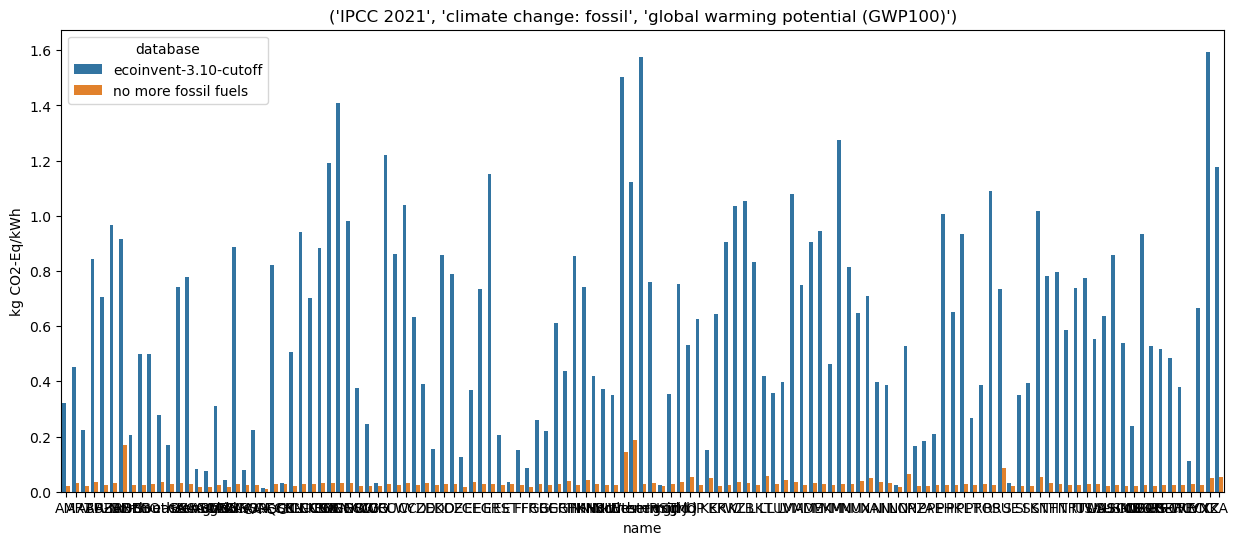

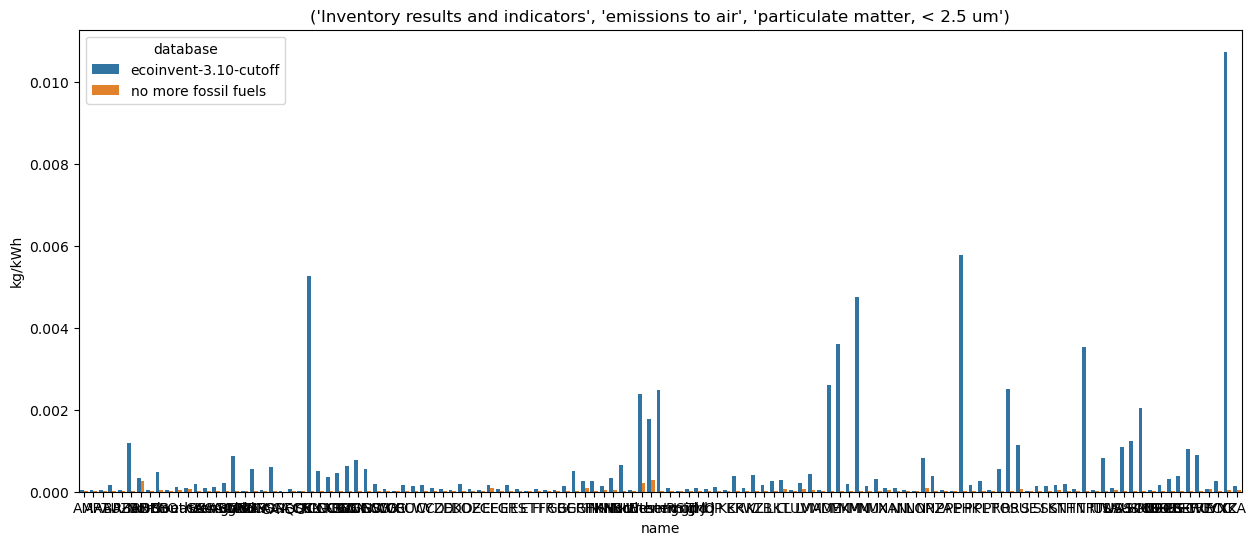

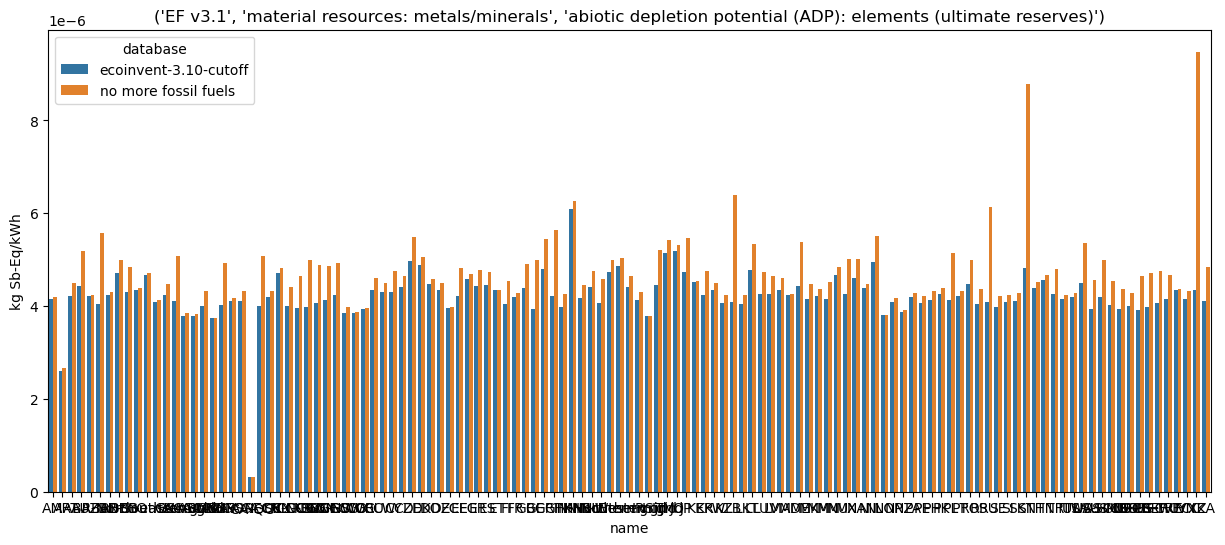

In [88]:
for method in methods:
    plt.figure(figsize=(15,6))
    # plot with seaborn barplot
    sns.barplot(data=df.loc[df["method"]==str(method)], x='name', y='score', hue='database')
    
    plt.xticks()
    plt.ylabel(f"{methods_units[method]}/kWh")
    plt.title(method)